# Implementing Naive Bayes in SciKit Learn

DS 5001 Text as Data

# Config

In [35]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [36]:
data_prefix = 'winereviews'
data_path = f'{data_home}/{data_prefix}/{data_prefix}'
class Params:
    test_size = 0.25

# Import

In [37]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn.naive_bayes import MultinomialNB

# Get Data

We import our split data from the first notebook.

In [38]:
X_test = pd.read_pickle(f"{data_path}-X_test.csv.pickle").sort_index()
X_train = pd.read_pickle(f"{data_path}-X_train.csv.pickle").sort_index()
y_test = pd.read_pickle(f"{data_path}-y_test.csv.pickle").sort_index()
y_train = pd.read_pickle(f"{data_path}-y_train.csv.pickle").sort_index()

In [39]:
DOC = pd.read_csv(f"{data_path}-DOC_UNSPLIT.csv").set_index('doc_id')

# Apply Model

In [40]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_hat = pd.DataFrame(clf.predict(X_test), index=X_test.index)

# Evaluate Model

In [41]:
clf.score(X_test, y_test)

0.8005

In [42]:
RESULT = pd.concat([y_test, y_hat], axis=1)
RESULT.columns = ['doc_label', 'prediction']

In [43]:
RESULT['result'] = RESULT.doc_label == RESULT.prediction

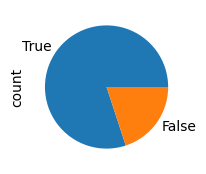

In [44]:
RESULT.value_counts('result').plot.pie(figsize=(2,2));

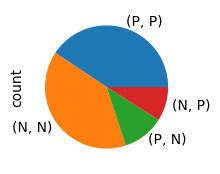

In [45]:
RESULT.value_counts(['prediction','doc_label']).plot.pie(figsize=(2,2));

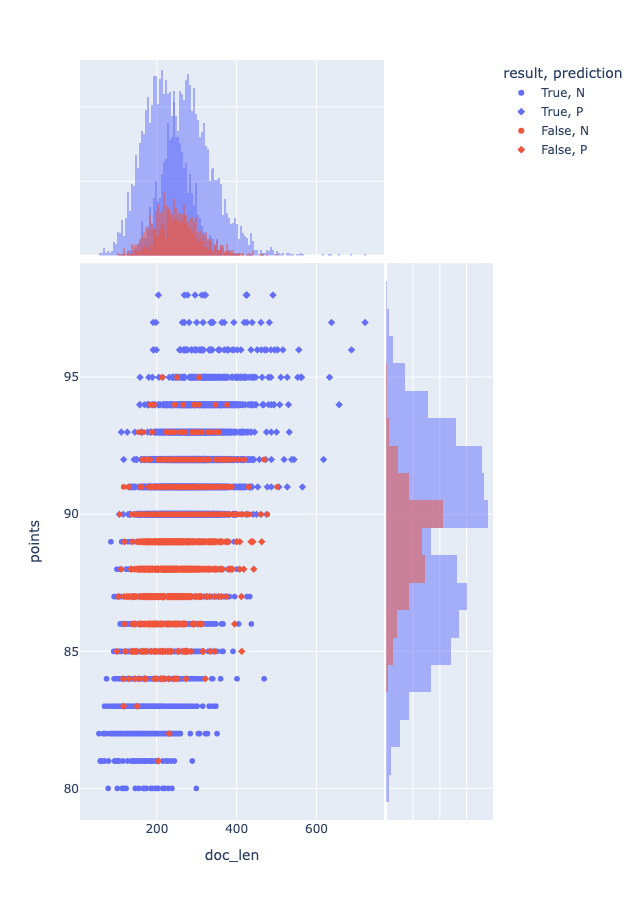

In [46]:
px.scatter(RESULT.join(DOC[['doc_content','points','doc_len']], how='inner').reset_index(), 'doc_len', 'points', color='result', symbol='prediction',
           height=900, width=1000, marginal_x='histogram', marginal_y='histogram')

In [47]:
CM = RESULT.value_counts(['prediction','doc_label']).unstack()

In [48]:
CM

doc_label      N     P
prediction            
N           3152   719
P            877  3252

In [49]:
def get_results(CM, model_id):
    
    R = pd.DataFrame(index=[model_id])
    R.index.name = 'model_id'

    R['TP'] = CM.iloc[0,0]   # hits
    R['FP'] = CM.iloc[0,1]   # Type I errors or false alarms
    R['TN'] = CM.iloc[1,1]   # correct rejections
    R['FN'] = CM.iloc[1,0]   # Type II errors or misses
    R['T'] = R.TP + R.TN     # All True
    R['F'] = R.FP + R.FN     # All False
    R['ALL'] = R['T'] + R.F  # All
    
    assert R.ALL.values[0] == CM.sum().sum()
    
    R['ACC'] = R['T'] / R.ALL                        # (Simple) Accuracy
    R['TPR'] = R.TP / (R.TP + R.FN)                  # Recall or Sensitivity
    R['TNR'] = R.TN / (R.TN + R.FP)                  # Specificity
    R['PPV'] = R.TP / (R.TP + R.FP)                  # Precision or Positive predictive value 
    R['BA'] = (R.TNR + R.TPR) / 2                    # Balanced Accuracy
    R['F1'] = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN) # F-score where F = 1

    return R

In [50]:
R = get_results(CM, 'skmnb')

In [51]:
R.T.style.format(precision=2)

# Extract Sentiment

In [52]:
FLP = pd.DataFrame(clf.feature_log_prob_).T
FLP.columns = clf.classes_
FLP.index = X_train.columns

In [53]:
SALEX = FLP.copy()

In [54]:
SALEX['valence'] = FLP.P - FLP.N

In [55]:
SALEX.index.name = 'term_str'
SALEX = SALEX.sort_values('valence')
SALEX['polarity'] = np.sign(SALEX['valence'])
SALEX = SALEX.sort_values('valence')

In [56]:
from sklearn.preprocessing import MinMaxScaler

In [57]:
scaler = MinMaxScaler(feature_range=(-1, 1))
SALEX['normalized'] = scaler.fit_transform(SALEX[['valence']])

In [58]:
SALEX.sort_values('valence', ascending=False).head(20)

N         P   valence  polarity  normalized
term_str                                                        
92          -12.797807 -8.538612  4.259195       1.0    1.000000
2027        -12.797807 -8.709760  4.088047       1.0    0.961070
94          -12.797807 -9.001896  3.795911       1.0    0.894621
2030        -11.699195 -7.952074  3.747121       1.0    0.883523
exquisite   -12.797807 -9.338369  3.459439       1.0    0.818086
91          -12.104660 -8.670539  3.434121       1.0    0.812327
93          -12.104660 -8.736789  3.367871       1.0    0.797258
2028        -11.699195 -8.412127  3.287067       1.0    0.778878
chaparral   -12.797807 -9.659952  3.137855       1.0    0.744938
2032        -12.797807 -9.695043  3.102764       1.0    0.736956
2035        -12.797807 -9.731411  3.066396       1.0    0.728684
deserves    -12.797807 -9.769151  3.028656       1.0    0.720100
sublime     -12.797807 -9.769151  3.028656       1.0    0.720100
2024        -11.006048 -8.030036  2.976012       1.0    0.708125
2031        -12.797807 -9.891754  2.906053       1.0    0.692212
2029        -12.797807 -9.891754  2.906053       1.0    0.692212
superbly    -12.797807 -9.936206  2.861602       1.0    0.682101
coiled      -12.797807 -9.936206  2.861602       1.0    0.682101
magnificent -12.797807 -9.982726  2.815082       1.0    0.671520
awesome     -12.797807 -9.982726  2.815082       1.0    0.671520

In [59]:
SALEX.sort_values('valence', ascending=True).head(20)

N          P   valence  polarity  normalized
term_str                                                       
everyday   -7.800595 -12.334101 -4.533506      -1.0   -1.000000
dilute     -8.865981 -13.027248 -4.161267      -1.0   -0.915330
watery     -8.969166 -13.027248 -4.058082      -1.0   -0.891859
raspy      -9.108928 -13.027248 -3.918320      -1.0   -0.860069
generic    -7.780527 -11.640954 -3.860426      -1.0   -0.846900
weedy      -9.430511 -13.027248 -3.596737      -1.0   -0.786921
pizza      -8.846563 -12.334101 -3.487537      -1.0   -0.762083
fuss       -9.578931 -13.027248 -3.448317      -1.0   -0.753161
murky      -9.578931 -13.027248 -3.448317      -1.0   -0.753161
informal   -8.493742 -11.928636 -3.434894      -1.0   -0.750108
simple     -6.191157  -9.561512 -3.370355      -1.0   -0.735428
bland      -8.991145 -12.334101 -3.342956      -1.0   -0.729196
diluted    -9.706765 -13.027248 -3.320483      -1.0   -0.724084
mealy      -9.060137 -12.334101 -3.273963      -1.0   -0.713503
torrontés  -9.802075 -13.027248 -3.225173      -1.0   -0.702405
detracts   -9.853368 -13.027248 -3.173880      -1.0   -0.690738
sugary     -7.922610 -11.081338 -3.158728      -1.0   -0.687291
quaffer    -9.301300 -12.334101 -3.032801      -1.0   -0.658648
struggles -10.025218 -13.027248 -3.002030      -1.0   -0.651648
strained  -10.025218 -13.027248 -3.002030      -1.0   -0.651648

**Ratio of positive to negative terms**

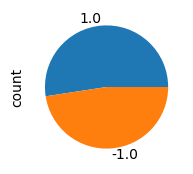

In [60]:
SALEX.polarity.value_counts().plot.pie(figsize=(2,2));

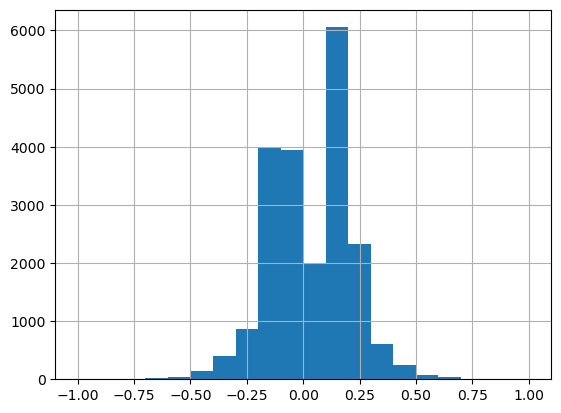

In [61]:
SALEX.normalized.hist(bins=20);

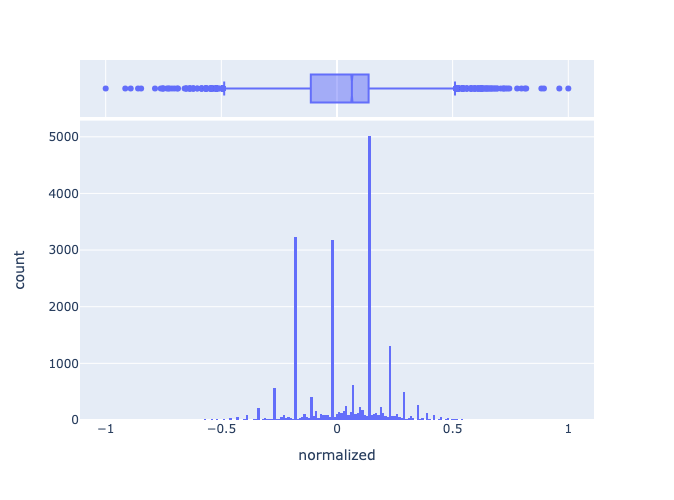

In [62]:
px.histogram(SALEX.reset_index(), x='normalized', hover_name='term_str', marginal='box', width=700, height=500)

In [63]:
(SALEX.normalized < -.5).sum()

76

In [64]:
(SALEX.normalized > .5).sum()

118

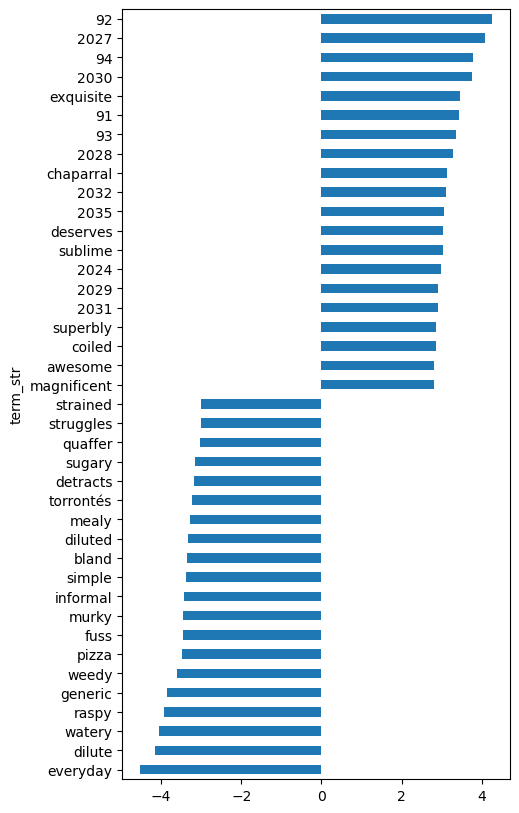

In [65]:
pd.concat([SALEX.valence.head(20),SALEX.valence.tail(20)]).plot.barh(figsize=(5,10));

In [66]:
SALEX

N          P   valence  polarity  normalized
term_str                                                       
everyday   -7.800595 -12.334101 -4.533506      -1.0   -1.000000
dilute     -8.865981 -13.027248 -4.161267      -1.0   -0.915330
watery     -8.969166 -13.027248 -4.058082      -1.0   -0.891859
raspy      -9.108928 -13.027248 -3.918320      -1.0   -0.860069
generic    -7.780527 -11.640954 -3.860426      -1.0   -0.846900
...              ...        ...       ...       ...         ...
exquisite -12.797807  -9.338369  3.459439       1.0    0.818086
2030      -11.699195  -7.952074  3.747121       1.0    0.883523
94        -12.797807  -9.001896  3.795911       1.0    0.894621
2027      -12.797807  -8.709760  4.088047       1.0    0.961070
92        -12.797807  -8.538612  4.259195       1.0    1.000000

[20772 rows x 5 columns]

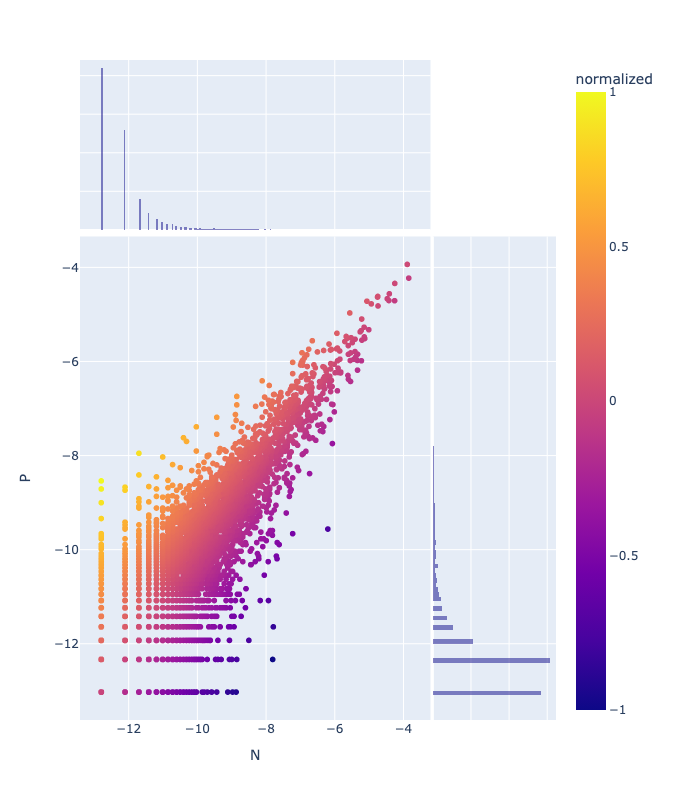

In [67]:
px.scatter(SALEX.reset_index(), 'N', 'P', 
           color='normalized', 
           height=800, width=1000, 
           hover_name='term_str', 
           marginal_x='histogram', marginal_y='histogram')

# Save

In [68]:
SALEX.to_csv(f"{data_path}-SKMNB_SALEX.csv")
R.to_csv(f"{data_path}-SKMNB_RESULT.csv", index=True)